In [2]:
import cv2
import numpy as np
import scipy.ndimage
import scipy.sparse
import scipy.sparse.linalg  


from skimage import feature

def make_system(L, sparse_map, constraint_factor=0.001):
    '''

    :param L: Laplacian Matrix.
    Check the paper "A closed-form solution to natural image matting"
    :param sparse_map: Estimated sparse blur values
    :param constraint_factor: Internal parameter for propagation
    :return: System parameters to solve for defocus blur propagation
    '''
    spflatten = sparse_map.ravel()

    D = scipy.sparse.diags(spflatten)

    # combine constraints and graph laplacian
    A = constraint_factor * D + L
    # constrained values of known alpha values
    b = constraint_factor * D * spflatten

    return A, b


def g1x(x, y, s1):
    '''

    :param x:
    :param y:
    :param s1:
    :return:
    '''
    s1sq = s1 ** 2
    g = -1 * np.multiply(np.divide(x, 2 * np.pi * s1sq ** 2),
                         np.exp(-1 * np.divide(x ** 2 + y ** 2, 2 * s1sq)))

    return g


def g1y(x, y, s1):
    '''

    :param x:
    :param y:
    :param s1:
    :return:
    '''
    s1sq = s1 ** 2
    g = -1 * np.multiply(np.divide(y, 2 * np.pi * s1sq ** 2),
                         np.exp(-1 * np.divide(x ** 2 + y ** 2, 2 * s1sq)))

    return g


def get_laplacian(I, r=1):
    '''

    :param I: An RGB image [0-1]
    :param r: radius
    :return: The Laplacian matrix explained in Levin's paper
    '''
    eps = 0.0000001
    h, w, c = I.shape
    wr = (2 * r + 1) * (2 * r + 1)

    M_idx = np.arange(h * w).reshape(w, h).T
    n_vals = (w - 2 * r) * (h - 2 * r) * wr ** 2

    # data for matting laplacian in coordinate form
    row_idx = np.zeros(n_vals, dtype=np.int64)
    col_idx = np.zeros(n_vals, dtype=np.int64)
    vals = np.zeros(n_vals, dtype=np.float64)
    lenr = 0

    for j in range(r, h - r):
        for i in range(r, w - r):
            winr = I[j - r:j + r + 1, i - r:i + r + 1, 2]
            wing = I[j - r:j + r + 1, i - r:i + r + 1, 1]
            winb = I[j - r:j + r + 1, i - r:i + r + 1, 0]
            win_idx = M_idx[j - r:j + r + 1, i - r:i + r + 1].T.ravel()

            meanwinr = winr.mean()
            winrsq = np.multiply(winr, winr)
            varI_rr = winrsq.sum() / wr - meanwinr ** 2

            meanwing = wing.mean()
            wingsq = np.multiply(wing, wing)
            varI_gg = wingsq.sum() / wr - meanwing ** 2

            meanwinb = winb.mean()
            winbsq = np.multiply(winb, winb)
            varI_bb = winbsq.sum() / wr - meanwinb ** 2

            winrgsq = np.multiply(winr, wing)
            varI_rg = winrgsq.sum() / wr - meanwinr * meanwing

            winrbsq = np.multiply(winr, winb)
            varI_rb = winrbsq.sum() / wr - meanwinr * meanwinb

            wingbsq = np.multiply(wing, winb)
            varI_gb = wingbsq.sum() / wr - meanwing * meanwinb

            Sigma = np.array([[varI_rr, varI_rg, varI_rb],
                              [varI_rg, varI_gg, varI_gb],
                              [varI_rb, varI_gb, varI_bb]])

            meanI = np.array([meanwinr, meanwing, meanwinb])

            Sigma = Sigma + eps * np.eye(3)

            winI = np.zeros((wr, c))

            winI[:, 0] = winr.T.ravel()
            winI[:, 1] = wing.T.ravel()
            winI[:, 2] = winb.T.ravel()

            winI = winI - meanI

            inv_cov = np.linalg.inv(Sigma)
            tvals = (1 + np.matmul(np.matmul(winI, inv_cov), winI.T)) / wr

            row_idx[lenr:wr ** 2 + lenr] = np.tile(win_idx, (1, wr)).ravel()
            col_idx[lenr:wr ** 2 + lenr] = np.tile(win_idx, (wr, 1)).T.ravel()
            vals[lenr:wr ** 2 + lenr] = tvals.T.ravel()

            lenr += wr ** 2

    # Lsparse = scipy.sparse.coo_matrix((vals, (row_idx, col_idx)), shape=(h*w, h*w))
    Lsparse = scipy.sparse.coo_matrix((vals, (row_idx, col_idx)), shape=(w * h, w * h))

    row_idx2 = np.zeros(w * h, dtype=np.int64)
    col_idx2 = np.zeros(w * h, dtype=np.int64)
    vals2 = np.zeros(w * h, dtype=np.float64)

    row_idx2[:] = np.arange(w * h)
    col_idx2[:] = np.arange(w * h)
    vals2[:] = Lsparse.sum(axis=1).ravel()

    LDsparse = scipy.sparse.coo_matrix((vals2, (row_idx2, col_idx2)), shape=(w * h, w * h))

    return LDsparse - Lsparse


def estimate_sparse_blur(gimg, edge_map, std1, std2):
    '''

    :param gimg: Grayscale image
    :param edge_map: An edge map of the image
    :param std1: Standard deviation of reblurring
    :param std2: Standard deviation of second reblurring
    :return: Estimated sparse blur values at edge locations
    '''
    half_window = 11
    m = half_window * 2 + 1
    a = np.arange(-half_window, half_window + 1)
    xmesh = np.tile(a, (m, 1))
    ymesh = xmesh.T

    f11 = g1x(xmesh, ymesh, std1)
    f12 = g1y(xmesh, ymesh, std1)

    f21 = g1x(xmesh, ymesh, std2)
    f22 = g1y(xmesh, ymesh, std2)

    gimx1 = scipy.ndimage.convolve(gimg, f11, mode='nearest')
    gimy1 = scipy.ndimage.convolve(gimg, f12, mode='nearest')
    mg1 = np.sqrt(gimx1 ** 2 + gimy1 ** 2)

    gimx2 = scipy.ndimage.convolve(gimg, f21, mode='nearest')
    gimy2 = scipy.ndimage.convolve(gimg, f22, mode='nearest')
    mg2 = np.sqrt(gimx2 ** 2 + gimy2 ** 2)

    R = np.divide(mg1, mg2)
    R = np.multiply(R, edge_map > 0)

    sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2)
    sparse_vals[sparse_vals < 0] = 0

    sparse_bmap = np.sqrt(sparse_vals)
    sparse_bmap[np.isnan(sparse_bmap)] = 0
    sparse_bmap[sparse_bmap > 5] = 5

    return sparse_bmap


def estimate_bmap_laplacian(img, sigma_c, std1, std2):
    '''

    :param img: An RGB image [0-255]
    :param sigma_c: Sigma parameter for Canny edge detector
    :param std1: Standard deviation of reblurring
    :param std2: Standard deviation of second reblurring
    :return: defocus blur map of the given image
    '''
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0
    edge_map = feature.canny(gimg, sigma_c)

    sparse_bmap = estimate_sparse_blur(gimg, edge_map, std1, std2)
    h, w = sparse_bmap.shape

    L1 = get_laplacian(img / 255.0)
    A, b = make_system(L1, sparse_bmap.T)

    bmap = scipy.sparse.linalg.spsolve(A, b).reshape(w, h).T

    return bmap

In [3]:
PARA = [22.84907876,14.49901409] # Parameters for blur to depth conversion  
def f(x,a,b): #d=5.6 -> 236.76648419 -107.80337788]
    return a*x**2 + b*x

In [11]:
def mouse_callback(event, x, y, flags, param):
    global O2
    global pa
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x," Y:", y)
        print('o changed value:', O2[y, x])
        print('dis : ', f(O2[y, x],*pa))
        #print('o2 value:', o_print[y//window_size, x//window_size])
        #cv.imwrite("compare.jpg",d)
        #print('d2 value:', d2[y, x])
        #print('o2 value:', temp[y, x])

In [4]:

image = './betch/T01/smallD/DSC06169.JPG'
img = cv2.imread(image)
img = cv2.resize(img,(576,288))
fblurmap = estimate_bmap_laplacian(img, sigma_c = 1, std1 = 1, std2 = 1.5)
print(fblurmap.max()," ",fblurmap.min())
cv2.imshow('image', np.uint8((fblurmap / fblurmap.max()) * 255))
O2 = fblurmap
cv2.setMouseCallback('image', mouse_callback)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite(image + '_bmap.png', np.uint8((fblurmap / fblurmap.max()) * 255))
np.save(image + '_bmap.npy', fblurmap)


3.8893078697020242   1.097900247795881
278  Y: 137
o changed value: 1.4473144538651572
dis :  68.84703500338767
265  Y: 149
o changed value: 1.52354087835233
dis :  75.12659236404077
287  Y: 190
o changed value: 1.364187326528356
dis :  62.30166819810272
308  Y: 149
o changed value: 1.5319310340936763
dis :  75.83399771056845
308  Y: 129
o changed value: 1.571954347678035
dis :  79.2527865810485
266  Y: 128
o changed value: 1.4505951677834672
dis :  69.11183316630984
125  Y: 151
o changed value: 1.668580319848584
dis :  87.80826717247166
133  Y: 152
o changed value: 1.6551426527212536
dis :  86.59292394794996
155  Y: 150
o changed value: 1.8041768901305921
dis :  100.53377709731534
125  Y: 156
o changed value: 1.6909400189349348
dis :  89.84883475195699
145  Y: 159
o changed value: 1.7225101278374437
dis :  92.76885531718617
154  Y: 158
o changed value: 1.9831698768156218
dis :  118.61858385725806
133  Y: 154
o changed value: 1.6549759233311436
dis :  86.57789626552645
386  Y: 126
o ch

In [5]:
import os
BAS = 20
def cal():
    head = os.listdir("./T")
    l_place = ["./T/"+i+"/L" for i in head]
    r_place = ["./T/"+i+"/R" for i in head]

    distance = [BAS+10*i for i in range(10)]


    fileL = [os.listdir(place) for place in l_place]
    fileR = [os.listdir(place) for place in r_place]

    R = [[cv2.imread(top+"/"+file) for file in img] for img,top in  zip(fileR,r_place)]
    L = [[cv2.imread(top+"/"+file) for file in img] for img,top in  zip(fileL,l_place)]
    #index = 4
    #R = [[cv.imread(r_place[index]+"/"+file) for file in fileR[index]]]
    #L = [[cv.imread(l_place[index]+"/"+file) for file in fileL[index]]]
    d = []
    o = []
    o_ori = []
    lower_blue = np.array([80, 50, 50])
    upper_blue = np.array([100, 255, 255])
    cal = list()
    print("OK")
    for r,l in zip(R,L):
        imagesR = r
        imagesL = l
        temp = list()
        count = 0
        for g1_,g2_ in zip(imagesR,imagesR):
            g1 = cv2.resize(g1_,(576,288))
            g2 = cv2.resize(g2_,(576,288))
            ori_g = cv2.cvtColor(g2,cv2.COLOR_BGR2HSV)
            fblurmap = estimate_bmap_laplacian(g1, sigma_c = 1, std1 = 1, std2 = 1.5)
            print("OK2")
            mask = cv2.inRange(ori_g, lower_blue, upper_blue)
            mask = cv2.erode(mask, None, iterations=3) #減少雜訊
            blue_region = cv2.bitwise_and(ori_g, ori_g, mask=mask)
            cor = cv2.findNonZero(mask)
            top,bottom,left,right = 0,0,0,0
            if cor is not None:
                cor = np.squeeze(cor)
                top , bottom , left , right = np.min(cor[:,1]),np.max(cor[:,1]),np.min(cor[:,0]),np.max(cor[:,0]) 
            region = fblurmap[top:bottom,left:right]
            temp.append(np.mean(region))
            count += 1
        cal.append(np.mean(temp))
    print(cal)
    return cal

In [4]:
import os
head = os.listdir("./bench")
l_place = ["./bench/"+i+"/largerD" for i in head[10:]]
r_place = ["./bench/"+i+"/smallD" for i in head[10:]]
fileL = [os.listdir(place) for place in l_place]
fileR = [os.listdir(place) for place in r_place]
R = [[top+"/"+file for file in img] for img,top in  zip(fileR,r_place)]
L = [[top+"/"+file for file in img] for img,top in  zip(fileL,l_place)]
MASK = [np.load(f"./bench_mask/T{i}.npy") for i in range(11,15)]
count = 0
for i,data in enumerate(zip(R,L,MASK)):
        print(f"{i+11}'s turn")
        imagesR = data[0]
        imagesL = data[1]
        for g1 in imagesR:
            error_file = open(f"T{i+11}_error.txt","+a")
            g1 = cv2.imread(g1)
            g1 = cv2.resize(g1,(576,288),interpolation=cv2.INTER_AREA)
            tt = cv2.getTickCount()
            fblurmap = estimate_bmap_laplacian(g1, sigma_c = 1, std1 = 1.2, std2 = 1.7)
            w_time = ((cv2.getTickCount() - tt) / cv2.getTickFrequency())
            print("Time:",w_time)
            error_file.write(f"{w_time},")
            unique_val = np.unique(data[2])
            unique_val = sorted(unique_val)
            error_rates = list()
            for val in unique_val:
                if val == 0:
                    continue
                position = np.where(data[2] == val)
                mean_val = np.mean(fblurmap[position])
                error_rate = (f(mean_val,*PARA) - val)/val
                error_file.write(f"{error_rate},")
                error_rates.append(error_rate)
                print(error_rate," val : ",val," mean: ",f(mean_val,*PARA))
            print("Error Rate:",np.mean(error_rates))
            error_file.write(f"{np.mean(error_rates)}\n")
            error_file.close()


11's turn
Time: 57.933348
0.9494076934876436  val :  54.3  mean:  105.85283775637905
Error Rate: 0.9494076934876436
Time: 57.8314876
0.9549310443126476  val :  54.3  mean:  106.15275570617676
Error Rate: 0.9549310443126476
Time: 57.6843939
0.9389800334368392  val :  54.3  mean:  105.28661581562037
Error Rate: 0.9389800334368392
Time: 57.7766286
0.9397516793844007  val :  54.3  mean:  105.32851619057296
Error Rate: 0.9397516793844007
Time: 57.8074818
0.9619161406092784  val :  54.3  mean:  106.53204643508381
Error Rate: 0.9619161406092784
12's turn
Time: 57.6914487
0.40159445324331944  val :  106.7  mean:  149.5501281610622
Error Rate: 0.40159445324331944
Time: 57.7394632
0.3840074670454982  val :  106.7  mean:  147.67359673375466
Error Rate: 0.3840074670454982
Time: 57.8013175
0.40333908246776395  val :  106.7  mean:  149.73628009931042
Error Rate: 0.40333908246776395
Time: 57.7836955
0.39513606793119416  val :  106.7  mean:  148.86101844825842
Error Rate: 0.39513606793119416
Time: 57.

In [6]:
result = cal()

OK
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
OK2
[0.7648351343471538, 0.7075402868818144, 0.7149520672254515, 0.7097307286043568, 0.7676107889081175, 0.8068659849777415, 0.798223672354289, 0.8505143530366629, 0.8450312914082495, 0.9154854749011887]


In [7]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
def compute_model(table):
    para,_ = curve_fit(f, list(table.keys()),list(table.values()))
    #models = np.poly1d(np.polyfit(list(table.keys()),list(table.values()),2))
    polyline = np.linspace(0,0.002,1000)
    plt.scatter(list(table.keys()),list(table.values()),color='r',label="data")
    plt.plot(polyline,f(polyline,*para),label="polyfit")
    plt.title("模糊度與實際距離的關係")
    plt.xlabel("模糊度")
    plt.ylabel("實際距離(cm)")
    plt.legend()
    plt.show()
    print(para)

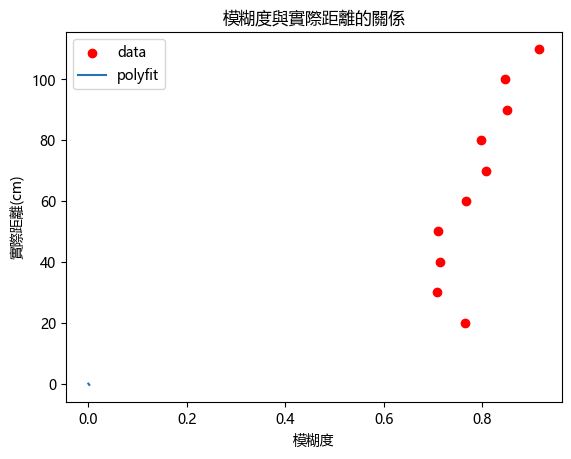

[ 374.64824224 -214.80128675]


In [8]:
distance = [BAS+10*i for i in range(10)]
dictionary = {result[i]:distance[i] for i in range(10)}
compute_model(dictionary)